# Breast density calculation using quantitive analysis of mammographic images 


### Purpose
Breast density is an important independent breast cancer risk factor.
Breast density reading is not a part of the standard screening examination due to
time considerations. Purpose of this project was to assess predictive power of computer
algorithms for breast density reading using quantitative analysis of mammographic
images. 

### Data and methods
We used 4624 processed mamogramms
recorded by Siemens scanners. Images were part of the DORA (Slovenian Breast Cancer Screening Programme) data base. Breast segmentation and feature generation were performed using LIBRA software. We used statistical method mRMR for feature selection. Classifier was based on fully-connected neural network. Predictive power was assessed by calculating Cohen's coefficient κ. 

### Results
Our model scored kappa value of 0.61 which we can interpret as moderate agreement. We get very similar results using classifier based on multinomial logistic regression. 


## Data
We used 4624 processed mammograms from Slovenian Breast Cancer Screening Programme (DORA) database. For each patient we had 2 pairs of raw and processed images of same breast in CC and MLO views. Patients had density determined only on one breast (either left or right). 
Breast density reading was performed only on images that were deamed suspicious. A futher diagnosis, however, found no cancer and patients were returned to DORA program. This means our dataset was atypical and biased. 

## Density classification
Breast density was classified using BI-RADS atlas which consists of 4 density classes. First class includes breats with low density and last (fourth) class breasts with highest density. 

First we import necessary modules

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
import pymrmr
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.stats import zscore

Segmentation and feature generation was performed using LIBRA software. Features were extracted and saved in an excel spreadsheet (.xlxs).

In [2]:
data = pd.read_excel('anonymizedDensityTable.xlsx') # open excel file using pandas

The file contains features from raw and processed mammograms. In this analysus we focused only on processed images. Each patient had breast density class defined only for one breast (either left or right). We filtered out breasts with empty density input. 

In [3]:
data = data[data.density != 0] # filter out breasts with no density input
data_processed = data[data.presentationIntentType == 'FOR PRESENTATION'] # filter out raw ("FOR PROCESSING") images
# we are now left with only processed ("FOR PRESENTATION") images

For our analysis we can discard ['Key', 'viewPosition', 'imageLaterality', 'studyDate',
       'study', 'series', 'file', 'institutionName', 'Manufacturer',
       'presentationIntentType'] columns.

In [4]:
data_processed.columns[1:20] # we will discard first few columns.

Index(['Key', 'viewPosition', 'imageLaterality', 'studyDate', 'density',
       'study', 'series', 'file', 'institutionName', 'Manufacturer',
       'presentationIntentType', 'moment3', 'moment4', 'moment5', 'range',
       'skewness', 'kurtosis', 'PatientAge', 'BodyPartThickness'],
      dtype='object')

In [5]:
density = data_processed.density # we need to save density column
data_processed=data_processed.drop(columns=data_processed.columns[0:12],axis=1).apply(zscore) #discard first few columns and apply z-score normalization

With z-score normalization we make features more comparable with one another.

In [6]:
data_final = data_processed.dropna(axis=1) # there are 3 columns with a lot of NaN values. We can drop those 3 columns (features)


In [7]:
data_final


,moment3,moment4,moment5,range,skewness,kurtosis,PatientAge,BodyPartThickness,CompressionForce,Exposure,...,Orientation_df_mean,ConvexArea_df_mean,Solidity_df_mean,Extent_df_mean,Perimeter_df_mean,Contrast_df_mean,Correlation_df_mean,Energy_df_mean,Homogeneity_df_mean,Entropy_df_mean
4,-0.281479,-0.045502,-0.027825,1.136032,-0.231991,0.281277,0.412655,-1.172179,1.639159,-0.272179,...,0.023047,3.152284,-0.396801,-0.053608,-0.051569,0.007689,-0.934591,-0.122998,0.007688,-0.039911
6,0.396827,0.364207,0.760360,-0.182639,0.477593,0.597057,0.412655,-1.381850,1.580024,-0.438957,...,0.021574,0.708211,-0.320376,-0.034396,-0.021088,0.013395,0.451380,-0.132484,0.013394,-0.039392
10,-0.371324,-0.395874,0.343566,-0.015036,0.098497,2.991188,1.240615,1.903007,-1.633976,1.136170,...,0.341943,0.387886,-3.303309,-0.475242,-0.019228,0.021857,-0.611890,-1.646683,0.021855,-0.387888
14,-1.389567,-1.786668,-1.173511,0.389195,-1.409681,-1.089927,1.240615,0.784757,0.879272,1.488257,...,-0.005092,1.632230,-0.385114,-0.071282,0.003173,0.030120,-2.255885,-0.221465,0.030119,-0.064908
16,1.313371,0.512965,0.718253,-1.712929,1.163325,-0.004204,-1.243265,0.225633,2.067890,1.432665,...,0.022666,-1.208315,0.941764,0.064038,0.017294,0.008738,0.410798,0.143208,0.008737,0.018195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18062,-1.876011,-1.023883,-1.784291,1.241258,-1.853414,-1.103159,1.571799,0.155742,-0.607980,0.042846,...,0.022160,-0.640687,-0.169179,-0.037156,-0.022073,-0.004819,-0.390380,-0.049485,-0.004821,-0.025186
18070,-1.235389,-1.184830,-1.181574,1.637239,-1.238041,0.817221,1.075023,-0.053929,-1.633976,0.394934,...,0.023273,0.607020,-0.349575,-0.060813,-0.021458,-0.004469,-4.864469,-0.127436,-0.004471,-0.046638
18072,-0.431306,0.104705,-0.046401,0.833080,-0.388509,0.427141,1.075023,0.225633,0.515590,0.376403,...,0.170888,-0.310508,-0.256162,-0.046167,-0.022684,0.176147,-1.218371,-0.146318,0.176145,-0.044246
18076,-1.006259,-1.353343,-1.051394,-0.059520,-1.025978,-1.346431,-0.580897,0.714867,0.973888,0.617305,...,0.022869,-0.264346,0.048461,-0.013868,-0.020752,0.013245,-0.256969,-0.064484,0.013244,-0.029827


We now have 135 features. For our prediction model (we want to predict density class) we need to select a much smaller sample of most relevant features. One of the well known feature selection algorithms is ANOVA. ANOVA ranks features by their relevance but doesn't take into account their redundancy.   

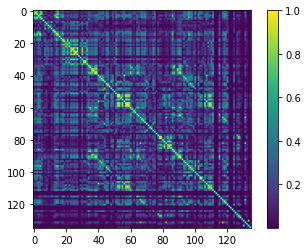

In [8]:
corrMatrix = data_final.corr() # we can plot correlation matrix of our features

import matplotlib.pyplot as plt

plt.imshow(abs(corrMatrix)) # we will plot absolute values of correlation
plt.colorbar()
plt.show()

If we plot correlation matrix we can see that many features show strong (absolute) correlation with one another. 

A good algorith for finding a set features with high relevancy and minimal redundancy is mRMR. It is implemented in pymrmr library.

In [9]:
data_final.insert(0, "density", density) # we put density column back in our dataset
mrmr_names = pymrmr.mRMR(data_final, 'MIQ', 20) # pymrmr.mRMR algorithm requires first column label
# we will select 20 features with highest 'MIQ' score - set of features with high relevancy and low redundancy
mrmr_names

['lo_win',
 'Orientation_last',
 'mean_last',
 'PatientAge',
 'max_diff_yext',
 'KVP',
 'MajorAxisLength_last',
 'range_df_last',
 'hi_win',
 'stdev',
 'MinorAxisLength_df_mean',
 'EulerNumber_df_last',
 'max_diff_xext',
 'intensity_mean_diff_last',
 'Correlation_mean',
 'Contrast',
 'Entropy_df_last',
 'Eccentricity_df_mean',
 'mean_mean',
 'Orientation_df_mean']

We can now build a simple model

In [26]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(20, activation='relu', input_dim=20))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='sgd', loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])

In [27]:
data_final

,density,moment3,moment4,moment5,range,skewness,kurtosis,PatientAge,BodyPartThickness,CompressionForce,...,Orientation_df_mean,ConvexArea_df_mean,Solidity_df_mean,Extent_df_mean,Perimeter_df_mean,Contrast_df_mean,Correlation_df_mean,Energy_df_mean,Homogeneity_df_mean,Entropy_df_mean
4,1006,-0.281479,-0.045502,-0.027825,1.136032,-0.231991,0.281277,0.412655,-1.172179,1.639159,...,0.023047,3.152284,-0.396801,-0.053608,-0.051569,0.007689,-0.934591,-0.122998,0.007688,-0.039911
6,1006,0.396827,0.364207,0.760360,-0.182639,0.477593,0.597057,0.412655,-1.381850,1.580024,...,0.021574,0.708211,-0.320376,-0.034396,-0.021088,0.013395,0.451380,-0.132484,0.013394,-0.039392
10,1005,-0.371324,-0.395874,0.343566,-0.015036,0.098497,2.991188,1.240615,1.903007,-1.633976,...,0.341943,0.387886,-3.303309,-0.475242,-0.019228,0.021857,-0.611890,-1.646683,0.021855,-0.387888
14,1005,-1.389567,-1.786668,-1.173511,0.389195,-1.409681,-1.089927,1.240615,0.784757,0.879272,...,-0.005092,1.632230,-0.385114,-0.071282,0.003173,0.030120,-2.255885,-0.221465,0.030119,-0.064908
16,1007,1.313371,0.512965,0.718253,-1.712929,1.163325,-0.004204,-1.243265,0.225633,2.067890,...,0.022666,-1.208315,0.941764,0.064038,0.017294,0.008738,0.410798,0.143208,0.008737,0.018195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18062,1005,-1.876011,-1.023883,-1.784291,1.241258,-1.853414,-1.103159,1.571799,0.155742,-0.607980,...,0.022160,-0.640687,-0.169179,-0.037156,-0.022073,-0.004819,-0.390380,-0.049485,-0.004821,-0.025186
18070,1005,-1.235389,-1.184830,-1.181574,1.637239,-1.238041,0.817221,1.075023,-0.053929,-1.633976,...,0.023273,0.607020,-0.349575,-0.060813,-0.021458,-0.004469,-4.864469,-0.127436,-0.004471,-0.046638
18072,1005,-0.431306,0.104705,-0.046401,0.833080,-0.388509,0.427141,1.075023,0.225633,0.515590,...,0.170888,-0.310508,-0.256162,-0.046167,-0.022684,0.176147,-1.218371,-0.146318,0.176145,-0.044246
18076,1005,-1.006259,-1.353343,-1.051394,-0.059520,-1.025978,-1.346431,-0.580897,0.714867,0.973888,...,0.022869,-0.264346,0.048461,-0.013868,-0.020752,0.013245,-0.256969,-0.064484,0.013244,-0.029827


In [28]:
from sklearn.utils import resample

x = data_final
x_1, x_2 = train_test_split(x, test_size=0.30, random_state=1) # split data into training and testing set

Our dataset is highly unbalanced. Most breasts had density class 1006, while classes 1005, 1007 and 1008 were in minority.

In [29]:
x_1.groupby("density").size() # show number of data in each density class of training set x_1

density
1005     703
1006    1636
1007     831
1008      66
dtype: int64

In [30]:
ss1005 = x_1[x_1.density==1005] # split data by their density label
ss1006 = x_1[x_1.density==1006]
ss1007 = x_1[x_1.density==1007]
ss1008 = x_1[x_1.density==1008]

s1,s2 = np.shape(ss1006) # find number of images with density 1006

# Supersample minority classes
# Minority classes will have same number of entries 
ss1005 = resample(ss1005, replace=True, n_samples=s1, random_state=1)
ss1007 = resample(ss1007, replace=True, n_samples=s1, random_state=1)
ss1008 = resample(ss1008, replace=True, n_samples=s1, random_state=1)


x_1 = pd.concat([ss1005,ss1006,ss1007,ss1008]) # we have no generated balanced dataset

In [31]:
y_1 = x_1.density.replace([1005,1006,1007,1008],[0,1,2,3]).values # replace labels and make it nice again with .values
y_2 = x_2.density.replace([1005,1006,1007,1008],[0,1,2,3]).values

x_1 = x_1.drop(columns=["density"]) # drop density/label column
x_2 = x_2.drop(columns=["density"]) # drop density/label column
x_1 = x_1[mrmr_names].values # only relevant columns 
x_2 = x_2[mrmr_names].values # only relevant columns 


In [32]:
from keras.utils import to_categorical # use this function for 'one hot encoding' of our labels (density)

y_1 = to_categorical(y_1, num_classes=4)
y_2 = to_categorical(y_2, num_classes=4)

We can now finally train the model

In [33]:
model.fit(x_1,y_1,epochs=5,batch_size=10) 

Epoch 1/5
655/655 [==============================] - 1s 1ms/step - loss: 1.2016 - accuracy: 0.4395
Epoch 2/5
655/655 [==============================] - 1s 1ms/step - loss: 0.8463 - accuracy: 0.6256
Epoch 3/5
655/655 [==============================] - 1s 895us/step - loss: 0.7634 - accuracy: 0.6686
Epoch 4/5
655/655 [==============================] - 1s 869us/step - loss: 0.7394 - accuracy: 0.6715
Epoch 5/5
655/655 [==============================] - 1s 832us/step - loss: 0.7002 - accuracy: 0.7022


In [34]:
score=model.evaluate(x_2,y_2) # evaluate model on test set

44/44 [==============================] - 0s 1ms/step - loss: 0.9363 - accuracy: 0.5677


In [35]:
prediction = model.predict(x_2) # make predictions on test set

Create a function that reverses 'one hot encoding'

In [36]:
def fix_prediction(x): # this function will reverse label encoding
    xs,ys = np.shape(x)
    newvector = np.zeros(xs)
    for i in range(xs):
        m = np.argmax(x[i])
        newvector[i]=m
    return newvector

<AxesSubplot:>

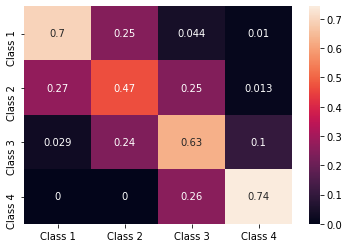

In [42]:
import seaborn as sns
import sklearn 
labels= ["Class 1", "Class 2", "Class 3", "Class 4"]

matrix=sklearn.metrics.confusion_matrix(fix_prediction(y_2),fix_prediction(prediction),normalize="true") # confusion matrix
sns.heatmap(matrix, annot=True, xticklabels=labels, yticklabels=labels) # we will normalize 

A good metric to assess predictive power is Cohens kappa coefficient

In [38]:
sklearn.metrics.cohen_kappa_score(fix_prediction(y_2), fix_prediction(prediction), labels=None, weights='quadratic')

0.6204397120630338

"One way to interpret kappa is with this scale (1): \
\
Kappa < 0: No agreement\
Kappa between 0.00 and 0.20: Slight agreement \
Kappa between 0.21 and 0.40: Fair agreement \
Kappa between 0.41 and 0.60: Moderate agreement \
Kappa between 0.61 and 0.80: Substantial agreement \
Kappa between 0.81 and 1.00: Almost perfect agreement."
1. Landis, J.R.; Koch, G.G. (1977). The measurement of observer agreement for categorical data. Biometrics. 33 (1): 159-174. https://doi.org/10.2307%2F2529310

We have substantial agreement (Kappa = 0.62)

We can also develop a model using multinomial logistic regression from sklearn python module

In [39]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver="newton-cg",multi_class="multinomial",max_iter=200).fit(x_1, fix_prediction(y_1))
pred_lg=clf.predict(x_2)

<AxesSubplot:>

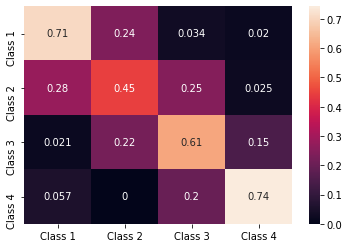

In [43]:
import seaborn as sns
import sklearn 

matrix=sklearn.metrics.confusion_matrix(fix_prediction(y_2),(pred_lg),normalize="true") # confusion matrix
sns.heatmap(matrix, annot=True,xticklabels=labels, yticklabels=labels) # we will normalize 

In [25]:
sklearn.metrics.cohen_kappa_score(fix_prediction(y_2), pred_lg, labels=None, weights='quadratic')

0.6061480963601681

Multinomial logistic regression gives very similar result.